In [56]:
import numpy as np
import chaospy as ch
from scipy import integrate
import pandas as pd
import time
import json
import pandas as pd
import datetime
import numpoly
from itertools import product
from collections import OrderedDict
import re
import os
import matplotlib as mpl


def c(s):
    os.chdir(s)
    return os.getcwd()

In [80]:


'''Preamble'''

import numpy as np
import chaospy as ch
from scipy import integrate
import pandas as pd
import time
import json
import pandas as pd
import datetime
import numpoly
from itertools import product
from collections import OrderedDict
import re
import os
import matplotlib.pyplot as plt


def c(s):
    os.chdir(s)
    return os.getcwd()
''''''

'''
 Notes
-------------------------
TODO > Remove indices in active that are in old before assigning errors > affects first step since 1111 already in old. 


'''


x0 = 33                         # Initial conditions same as before
y0 = 6.2
X = [x0,y0]
t = np.linspace(0., 30, 1000)

#Model

def lotka(X, t, alpha, beta, delta, gamma):
    x, y = X
    dotx = x * (alpha - beta * y)
    doty = y * (-delta + gamma * x)
    return np.array([dotx, doty])

#Parameter space

problem = {
    'num_vars': 4,
    'names': ['alpha','beta','delta','gamma'],
    'bounds': [[0.44,0.68],
               [0.02,0.044],
               [0.71,1.15],
               [0.0226,0.0354]]
}
##Parameters
alpha = ch.Uniform(0.44, 0.68) #We choose uniform distributions to reflect our lack of knowledge about the relative likelihood functions
beta = ch.Uniform(0.02, 0.044) #We take the same bounds as for the Sobol-Saltelli analysis
delta = ch.Uniform(0.71, 1.15)
gamma = ch.Uniform(0.0226, 0.0354)

joint = ch.J(alpha,beta,delta,gamma) #The input paramter distributions are assumed to be independent so we may easily construct the joint input probability distribution.



gt_prey = pd.read_csv('../data/indices_328000_GT.csv').ST
gt_norm = np.linalg.norm(gt_prey)


dick = {}

vectors = np.identity(len(joint), dtype='int')

growth=False
recurrence_algorithm='stieltjes'
rule='g'
tolerance=1e-10
scaling=3
n_max=50000


def _construct_lookup(
        orders,
        dists,
        growth,
        recurrence_algorithm,
        rules,
        tolerance,
        scaling,
        n_max,
):
    """
    Create abscissas and weights look-up table so values do not need to be
    re-calculatated on the fly.
    """
    x_lookup = []
    w_lookup = []

    for order, dist in zip(max_order_vector, dists):
        x_lookup.append([])
        w_lookup.append([])
        for orderr in range(max_order + 1):
            (abscissas,), weights = ch.generate_quadrature(
                order=orderr,
                dist=dist,
                growth=growth,
                recurrence_algorithm=recurrence_algorithm,
                rule=rule,
                tolerance=tolerance,
                scaling=scaling,
                n_max=n_max,
            )
            x_lookup[-1].append(abscissas)
            w_lookup[-1].append(weights)
    return x_lookup, w_lookup


def construct_wrapper(maxx):
    global max_order_vector, max_order
    global x_lookup, w_lookup

    max_order = maxx
    max_order_vector = max_order * np.ones(len(joint), dtype=int)
    # print(max_order_vector)

    x_lookup, w_lookup = _construct_lookup(
        orders=max_order_vector,
        dists=joint,
        growth=growth,
        recurrence_algorithm=recurrence_algorithm,
        rules=rule,
        tolerance=tolerance,
        scaling=scaling,
        n_max=5000)

    return x_lookup, w_lookup

x_lookup, w_lookup = construct_wrapper(10)


def generate_candidates(index_set, P):
    global candidates, pre_candidates, back_neighbours

    pre_candidates = []
    candidates = []

    for j in range(0, len(joint)):
        pre_candidates.append(index_set + vectors[j])

    for candidate in pre_candidates:
        back_neighbours = []
        for j in range(0, len(joint)):
            back_neighbour = candidate - vectors[j]
            if np.all((back_neighbour > 1)):
                back_neighbours.append(tuple(back_neighbour))

        if np.all([neighbour in old for neighbour in back_neighbours]):
            candidates.append(tuple(candidate))

    temp = []
    for candidate in candidates:
        # if candidate not in old:
        if (np.all(np.array(candidate) <= P) and np.linalg.norm(np.array(candidate),ord=1) <= (P+3)):
            temp.append(candidate)

    candidates = temp
    
    for candidate in candidates:
        if candidate in old:
            candidates.remove(candidate)

#     temp = []
#     maxx = sum(np.max(np.array(old), axis=0))

#     for candidate in candidates:

#         if sum(np.max(np.array(old + [candidate]), axis=0)) > maxx:
#             temp.append(candidate)

#     candidates = temp
    return candidates

def sobol_error(vec):
    return np.linalg.norm(gt_prey - vec) / gt_norm


def solver(old_set,target):

    global poly

    solver_time = time.perf_counter()

    nodes_list = []
    weights_list = []
    evals_list = []

    for index in old_set:
        nodes, weights = build_nodes_weights(index)
        weights = [weight * combinator(index) for weight in weights]

        nodes_list += nodes
        weights_list += weights

    for node in nodes_list:

        if node in dick.keys():
            evals_list.append(dick[node])

        else:
            a, b, d, g = node
            solution = integrate.odeint(lotka, X, t, args=(a, b, d, g)).T[target][910]
            evals_list.append(solution)
            dick[node] = solution

    nodes_list = np.array(nodes_list).T

    polly, uhat = ch.fit_regression(expansion,nodes_list, evals_list, retall = 1)
    poly.append(polly)
    # print('Solver_time >>>', time.perf_counter() - solver_time)
    return len(weights_list), uhat


def assign_errors(active_set):
    global active_errors, active, candidates, current_errors, new
    active_errors = []
    
    if np.any(active_set in old):
        print('oops')
    
#     maxx = sum(np.max(np.array(old), axis=0))

#     for multi_index in active_set:
#         if (step > 0) and sum(np.max(np.array(old + [multi_index]), axis=0)) <= maxx:
#             active_set.remove(multi_index)
   

    for multi_index in active_set:
        nodes, _ = build_nodes_weights(multi_index)
        current_errors = []

        for node in nodes:
            a, b, d, g = node
            if np.isnan(poly[-1](a, b, d, g)):
                poly_eval = 0
            else:
                poly_eval = poly[-1](a, b, d, g)

            if node in dick.keys():
                a, b, d, g = node
                current_errors.append(abs(dick[node] - poly_eval))

            else:
                solution = integrate.odeint(lotka, (33, 6.2), t, args=(a, b, d, g)).T[0][910]
                current_errors.append(abs(solution - poly_eval))

        active_errors.append(np.mean(current_errors))

    active = sorted(list(zip(active_set, active_errors)), key=lambda x: x[1])
    for i in active:
        if step > 1:
            if i[0] in old:
                active.remove(i)
       

    # print(active)
    return active
    # active = [i for i in OrderedDict((tuple(x[0]), x) for x in active).values()]if np.isnan(poly[-1](1,2,3,4)):

def algorithm(P,species,merge):
    
    global dick, old, candidates, poly, active, global_errors, no_nodes,step,expansion,means,uhats,local_errors
    
    '''Initialise'''
    
    if species == 'prey':
        target = 0
        
    elif species == 'predator':
        target = 1
    
    seed = (2,2,1,2)
    expansion = ch.generate_expansion(P, joint, normed = True)
    exponents = ch.lead_exponent(expansion, graded=True)
    vectors = np.identity(len(joint), dtype='int')
    date_today = datetime.date.today()
    start_time = time.perf_counter()
    
    step = 0
    
    old = [(1,1,1,1)]
    active = []
    poly = []
    uhats = []
    
    local_errors = []
    global_errors = []
    means = []
    
    names = ['alpha','beta','delta','gamma']
    
    df = pd.DataFrame(columns=['chosen_index','local_error','global_error','no_nodes','run_time'],dtype=object)
    df_indices = pd.DataFrame(columns=['alpha','beta','delta','gamma'],dtype=object)
    df_indices_s1 = pd.DataFrame(columns=['alpha','beta','delta','gamma'],dtype=object)

    
    '''Execute zeroth step'''
    
    trivial = [seed]
    number_nodes,uhat = solver(old,target)
    uhats.append(uhat)
    assign_errors(old)
    
    
    st = sense_t(uhat,exponents)
    s1 = sense_main(uhat,exponents)
    means.append(uhat[0])
    # print(uhat[0])
    
    global_errors.append(sobol_error(st))
    
    print('Global error >>>', global_errors[-1])
    print('Step time >>>', time.perf_counter() - start_time, 'seconds')
    print('-'*10,'break','-'*10)


    '''Main loop'''
    
    while (global_errors[-1] > 0.05 or np.isnan(global_errors[-1])) and len(active)>0:
        
        start_time = time.perf_counter()
        
#         print('Active >>>',active)
        chosen_index = active[-1][0]
        local_errors.append(active[-1][1])
        active.pop()
    
        old.append(chosen_index)
        
        print('Chosen index >>>', chosen_index)
        
        number_nodes,uhat = solver(old,target)
        uhats.append(uhat)
        
        candidates = generate_candidates(chosen_index,P)
        stripped_active = [i[0] for i in active] + [j for j in candidates]
        active = assign_errors(stripped_active)
        
        sobol_time = time.perf_counter() 

        st = sense_t(uhat,exponents)
        s1 = sense_main(uhat,exponents)
        means.append(uhat[0])
        print(uhat[0])

        
        # print('Sobol time >>>', time.perf_counter() - sobol_time)
        
        global_errors.append(sobol_error(st))

        print('Global error >>>', global_errors[-1])
        
        '''Save data'''
        run_time = time.perf_counter() - start_time
        
        numpoly.savez(f'../data/lotka2/{species}/poly_{P}+{date_today}.npz',*poly)
        np.savez(f'../data/lotka2/{species}/uhat_{P}+{date_today}.npz',*uhats)
        
        df_indices = df_indices.append({'alpha': st[0], 'beta': st[1], 'delta': st[2], 'gamma': st[3]          }, ignore_index=True)
        df_indices_s1 = df_indices_s1.append({'alpha': s1[0], 'beta': s1[1], 'delta': s1[2], 'gamma': s1[3]          }, ignore_index=True)
        df = df.append({'chosen_index': chosen_index,'local_error':local_errors[-1],                               'global_error':global_errors[-1],'no_nodes':number_nodes, 'run_time':run_time}, ignore_index=True)
        
        df.to_csv(f'../data/lotka2/{species}/run_file_{P}+{date_today}.csv')
        df_indices.to_csv(f'../data/lotka2/{species}/total_order_indices_{P}+{date_today}.csv')
        df_indices_s1.to_csv(f'../data/lotka2/{species}/first_order_indices_{P}+{date_today}.csv')

        print('Step time >>>', time.perf_counter() - start_time, 'seconds')
        print('-'*10,'break','-'*10)
        
        step += 1
        
    print('Congratulations, the algorithm has converged!')
    print('Here are the results...')
    print('-'*20)
    print(f'ST_alpha:{st[0].round(10)}, ST_beta:{st[1].round(10)}, ST_delta:{st[2].round(10)}, ST_gamma:{st[3].round(10)}')
    print(f'GT_alpha:{gt_prey[0].round(10)}, GT_beta:{gt_prey[1].round(10)}, GT_delta:{gt_prey[2].round(10)}, GT_gamma:{gt_prey[3].round(10)}')
    print(f'The final grid contains {number_nodes} nodes.')
    print(f'The total run time was {df.run_time.sum()}seconds, not bad!')
    
    if merge:
    
        merged_set = merge_sets(old,active)
        
        number_nodes,uhat = solver(merged_set, target)
            
        st = sense_t(uhat,exponents)
        s1 = sense_main(uhat,exponents)
        
        print('-'*10,'MERGED','-'*10)
        print(f'ST_alpha:{st[0].round(10)}, ST_beta:{st[1].round(10)}, ST_delta:{st[2].round(10)}, ST_gamma:{st[3].round(10)}')
        print(f'GT_alpha:{gt_prey[0].round(10)}, GT_beta:{gt_prey[1].round(10)}, GT_delta:{gt_prey[2].round(10)}, GT_gamma:{gt_prey[3].round(10)}')
        
        global_errors.append(sobol_error(st))

        print('Global error >>>', global_errors[-1])
            
        '''Save data'''
        run_time = time.perf_counter() - start_time
            
        numpoly.savez(f'../data/lotka2/{species}/poly_{P}+{date_today}.npz',*poly)
            
        df_indices = df_indices.append({'alpha': st[0], 'beta': st[1], 'delta': st[2], 'gamma': st[3]          }, ignore_index=True)
        df_indices_s1 = df_indices_s1.append({'alpha': s1[0], 'beta': s1[1], 'delta': s1[2], 'gamma': s1[3]          }, ignore_index=True)
        df = df.append({'chosen_index': chosen_index,'local_error':local_errors[-1],                               'global_error':global_errors[-1],'no_nodes':number_nodes, 'run_time':run_time}, ignore_index=True)
            
        df.to_csv(f'../data/lotka2/{species}/run_file_{P}+{date_today}.csv')
        df_indices.to_csv(f'../data/lotka2/{species}/total_order_indices_{P}+{date_today}.csv')
        df_indices_s1.to_csv(f'../data/lotka2/{species}/first_order_indices_{P}+{date_today}.csv')
        
    print(old)
    
       
def merge_sets(old_set,active):

    stripped_active = [i[0] for i in active]
    merged = old + stripped_active
    
    return merged
    
def plot_stat_convergence(means):
       
        K = len(means)
        if K < 2:
            print('Means from at least two refinements are required')
            return
        else:
            differ_mean = np.zeros(K - 1)
            differ_std = np.zeros(K - 1)
            for i in range(1, K):
                differ_mean[i - 1] = means[i] - means[i - 1]
                                                    
                # make relative
                differ_mean[i - 1] = differ_mean[i - 1] / means[i - 1]
                                                                         

                # differ_std[i - 1] = np.linalg.norm(self.std_history[i] -
                                                   # self.std_history[i - 1], np.inf)
                # # make relative
                # differ_std[i - 1] = differ_std[i - 1] / np.linalg.norm(self.std_history[i - 1],
                                                                       # np.inf)

        import matplotlib.pyplot as plt
        fig = plt.figure('stat_conv')
        ax1 = fig.add_subplot(111, title='moment convergence')
        ax1.set_xlabel('iteration', fontsize=12)
        # ax1.set_ylabel(r'$ ||\mathrm{mean}_i - \mathrm{mean}_{i - 1}||_\infty$',
        # color='r', fontsize=12)
        ax1.set_ylabel(r'relative error mean', color='r', fontsize=12)
        ax1.plot(range(2, K + 1), differ_mean, color='r', marker='+')
        ax1.tick_params(axis='y', labelcolor='r')
        plt.show()
        
        
def combinator(current_index):
    
    coeff = 1
    
    for vector in vectors:
        
        if tuple(np.array(current_index, dtype='int') + vector) in old:
            
            coeff += -1
            
    return coeff 

def build_nodes_weights(current_index):
    
    nodestack = []
    weightstack = []
    
    '''Nodes'''
    
    for index,element in enumerate(current_index):
        nodestack.append([])
        nodestack[index] = list(x_lookup[index][element])
        
    nodes = nodestack[0]
    
    for i in range(1,len(nodestack)):
        nodes = product(nodes,nodestack[i])
        
    nodes = [(a,b,c,d) for (((a,b),c),d) in nodes]
    
    '''Weights'''
    
    for index,element in enumerate(current_index):
        weightstack.append([])
        weightstack[index] = list(w_lookup[index][element])
        
    weights = weightstack[0]
    
    for i in range(1,len(weightstack)):
        weights = product(weights,weightstack[i])
        
    weights = [(a*b*c*d) for (((a,b),c),d) in weights]
    
    
    return nodes,weights

def sense_main(uhat,exponents):

    dim = len(joint)
    s1 = np.zeros(dim)
    
    variance = np.sum(np.array(uhat[1:])**2)
    
    for variable,name in enumerate(expansion.names):
        mask = np.ones(dim)
        mask[variable] = False
        
        for idx,exponent in enumerate(exponents):
            if exponent[variable] > 0 and np.all(exponent*mask == 0):
                s1[variable] += uhat[idx]**2
                
    s1 = s1 / variance
    
    return s1

def sense_t(uhat,exponents):
    
    dim = len(joint)
    st = np.zeros(dim)
    
    variance = np.sum(np.array(uhat[1:])**2)
    
    for variable,name in enumerate(expansion.names):

        mask = np.ones(dim)
        mask[variable] = False
        
        for idx,exponent in enumerate(exponents):
            if exponent[variable] > 0 and np.all(exponent*mask == 0):
                st[variable] += uhat[idx]**2
                
            if exponent[variable] > 0 and np.any(exponent*mask != 0):
                st[variable] += uhat[idx]**2
                
    st = st / variance
    
    return st
    
    
        
algorithm(3,'prey', merge=True)












Global error >>> 0.07184754135012249
Step time >>> 0.20208110000021406 seconds
---------- break ----------
Chosen index >>> (1, 1, 1, 1)
33.05030935450138
Global error >>> 0.07184754135012132
Step time >>> 1.1114761999997427 seconds
---------- break ----------
Chosen index >>> (1, 1, 2, 1)
31.654217135847794
Global error >>> 0.44714296798041675
Step time >>> 2.1027176000006875 seconds
---------- break ----------
Chosen index >>> (2, 1, 1, 1)
33.43804091821161
Global error >>> 0.7588702342791135
Step time >>> 3.2969794000000547 seconds
---------- break ----------
Chosen index >>> (1, 1, 2, 2)
32.790515381110566
Global error >>> 0.040514015901051484
Step time >>> 3.0987748999996256 seconds
---------- break ----------
Congratulations, the algorithm has converged!
Here are the results...
--------------------
ST_alpha:0.4151472108, ST_beta:0.1289254319, ST_delta:0.7593729808, ST_gamma:0.1131430046
GT_alpha:0.4328878939, GT_beta:0.1110628399, GT_delta:0.7788299388, GT_gamma:0.0950897987
The 

In [83]:
local_errors[-1]

6205527206417.017

In [79]:
local_errors

NameError: name 'local_errors' is not defined

In [76]:
test = [i for i in {i:0 for i in old}.keys()]
test

[(1, 1, 1, 1),
 (1, 1, 2, 1),
 (1, 1, 2, 2),
 (1, 2, 2, 2),
 (2, 1, 1, 1),
 (2, 2, 1, 1),
 (2, 2, 2, 2),
 (1, 3, 2, 2),
 (2, 2, 1, 2),
 (3, 2, 1, 1),
 (2, 2, 3, 2),
 (1, 3, 2, 3)]

In [90]:
test

Unnamed: 0        S1   S1_conf        ST   ST_conf
type params                                                    
prey alpha            0  0.159553  0.011018  0.432888  0.009446
     beta             1  0.009623  0.005220  0.111063  0.003751
     delta            2  0.493639  0.012931  0.778830  0.013850
     gamma            3  0.023204  0.004882  0.095090  0.004554
pred alpha            0  0.092187  0.014678  0.707774  0.021287
     beta             1  0.038260  0.007473  0.246944  0.009003
     delta            2  0.136526  0.017024  0.815647  0.022319
     gamma            3  0.002179  0.004539  0.085607  0.004358

In [89]:
gt_prey = pd.read_csv('../data/new_gt_indices_328000.csv',index_col=['type','params']).loc['pred','ST']
gt_prey

params
alpha    0.707774
beta     0.246944
delta    0.815647
gamma    0.085607
Name: ST, dtype: float64

In [69]:
old = test

In [26]:
test = [np.array(i) for i in test]
test

[array([1, 1, 1, 1]),
 array([1, 1, 2, 1]),
 array([2, 1, 1, 1]),
 array([1, 1, 2, 2])]

In [18]:
a = []
a.append(test[0])
a.append(test[1])
a

[array([1, 1, 1, 1]), array([1, 1, 2, 1])]

In [28]:
one = np.array([test[0] , test[1]])
one

array([[1, 1, 1, 1],
       [1, 1, 2, 1]])

In [30]:
np.max(np.array(one),axis=0) - test[0]

array([0, 0, 1, 0])

In [34]:
one

array([[1, 1, 1, 1],
       [1, 1, 2, 1]])

In [35]:
test[2]

array([2, 1, 1, 1])

In [33]:
np.concatenate((one,test[2]),axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [37]:
test

[array([1, 1, 1, 1]),
 array([1, 1, 2, 1]),
 array([2, 1, 1, 1]),
 array([1, 1, 2, 2])]

In [38]:
test[3]-test[2]

array([-1,  0,  1,  1])

(1, 1, 1, 1)

In [47]:
refinations = []
for i,ex in enumerate(old[1:len(old)]):
    print(ex)
    refinations.append(np.array(ex) - np.array(old[i-1]))
refinations

(1, 1, 2, 1)
(2, 1, 1, 1)
(1, 1, 2, 2)


[array([ 0,  0,  0, -1]), array([1, 0, 0, 0]), array([0, 0, 0, 1])]

In [48]:
old[0]

(1, 1, 1, 1)

In [73]:
refinations = []
for i in range(1,len(old)):
    refinations.append(np.array(old[i]) - np.array(old[i-1]))


In [53]:
refined = np.ones(4)

for i,ex in enumerate(refined):
    if refinations[2][i] == 1:
        refined[i] = True
    else:
        refined[i] = False
refined

array([0., 0., 1., 1.])

In [74]:
refinations

[array([0, 0, 1, 0]),
 array([ 0,  0, -1,  1]),
 array([ 1,  0,  1, -1]),
 array([0, 1, 0, 0]),
 array([-1,  0, -1,  1]),
 array([ 1, -1,  1,  0])]

In [78]:
old

[(1, 1, 1, 1),
 (1, 1, 1, 1),
 (1, 1, 2, 1),
 (1, 1, 2, 2),
 (1, 2, 2, 2),
 (2, 1, 1, 1),
 (2, 2, 1, 1),
 (2, 2, 2, 2),
 (1, 3, 2, 2),
 (2, 2, 1, 2),
 (3, 2, 1, 1),
 (2, 2, 3, 2),
 (1, 3, 2, 3)]

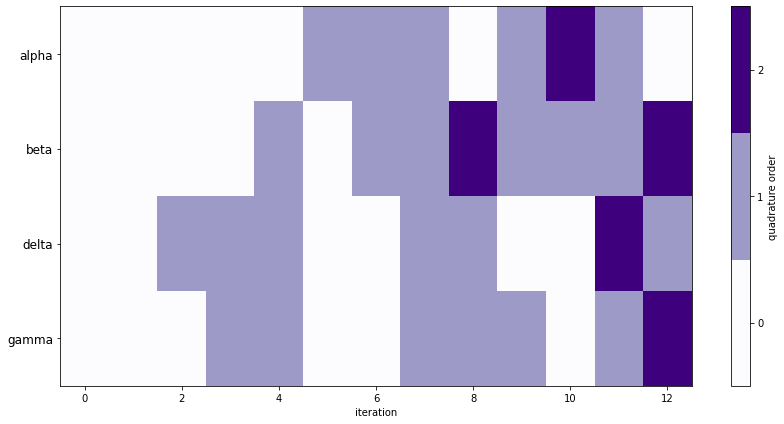

In [77]:
fig = plt.figure(figsize=[12, 6])
order = range(len(problem['names']))
ax = fig.add_subplot(111)
M = np.max(np.array(old))
cmap = plt.get_cmap('Purples', M)
plt.imshow(np.array(old).T, cmap=cmap, aspect='auto')
norm = mpl.colors.Normalize(vmin=0, vmax=M - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm)
p = np.linspace(0, M - 1, M + 1)
tick_p = 0.5 * (p[1:] + p[0:-1])
cb.set_ticks(tick_p)
cb.set_ticklabels(np.arange(M))
cb.set_label(r'quadrature order')
ax.set_yticks(range(np.array(old).shape[1]))
params = np.array(problem['names'])
ax.set_yticklabels(params[order], fontsize=12)
ax.set_xlabel('iteration')
plt.tight_layout()
plt.show()

In [71]:
test

[(1, 1, 1, 1),
 (1, 1, 2, 1),
 (1, 1, 1, 2),
 (2, 1, 2, 1),
 (2, 2, 2, 1),
 (1, 2, 1, 2),
 (2, 1, 2, 2)]